In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!ls ../../results/acrobot/acrobot_optimal_policies/


optimal_all_runs.pkl  optimal_per_shift.pkl
optimal_config.yaml   optimal_summary.tsv


In [ ]:
# read in the results from the per-shift retraining experiment
optimal_rewards = pd.read_csv('../../results/acrobot/acrobot_optimal_policies/optimal_summary.tsv', sep='\t')

In [26]:
from functools import cache

def maybe_get_value(run, key, i):
    try:
        returns = run[key][i]
    except KeyError:
        returns = None
    return returns

@cache
def load_data(fp: str, param: str = "length"):
    data = pd.read_pickle(fp)

    df_data = []
    # the data contains runs for a seed - each seed has 20 experiments with different
    # lengths - and at each length there are 250 evaluations - so need to unnest and
    # extract the relevant info.
    for exp in data:
        seed = exp["seed"]
        results = exp["results"]
        for run in results:
            length = run[param]
            for i in range(250):
                returns_conf = maybe_get_value(run, 'returns_conf', i)
                returns_ccnn = maybe_get_value(run, 'returns_ccnn', i)
                returns_noconf = maybe_get_value(run, 'returns_noconf', i)
                run_info = {
                    "seed": seed,
                    "run": i,
                    param: length,
                    "returns_noconf": returns_noconf,
                    "returns_conf": returns_conf,
                    "returns_ccnn": returns_ccnn,
                }
                returns_tta = maybe_get_value(run, 'returns_tta', i)
                if returns_tta is not None:
                    run_info.update({'returns_tta': returns_tta})
                df_data.append(run_info)

    return pd.DataFrame(df_data)

In [27]:
normal_df = load_data('../../results/acrobot/vanilla/robustness_experiment.pkl', 'LINK_LENGTH_1')

In [114]:
aggfunc = {'returns_noconf': ['mean', 'std']}
agg_df = normal_df.groupby(['seed', 'LINK_LENGTH_1'], as_index=False).agg(aggfunc)
agg_df.columns = [col[1] if col[1] else col[0] for col in agg_df.columns.values]
max_returns = agg_df.groupby(['LINK_LENGTH_1'])['mean'].max()
unoptimised_df = agg_df[agg_df['mean'].isin(max_returns)]
unoptimised_df = unoptimised_df.set_index('LINK_LENGTH_1')[['mean', 'std']]
unoptimised_df = unoptimised_df.sort_index()

In [115]:
# # filter out bad seeds
# agg_df = normal_df.groupby(['seed', 'LINK_LENGTH_1'], as_index=False)['returns_conf'].mean()
# nominal_df = agg_df[agg_df['LINK_LENGTH_1'] == 1.0]
# good_seeds = nominal_df.loc[nominal_df['returns_conf'] > -80, 'seed'].values
# agg_df = agg_df[agg_df['seed'].isin(good_seeds)]
# unoptimised_df = agg_df.groupby('LINK_LENGTH_1').agg({'returns_conf': ['mean', 'std']})
# unoptimised_df.columns = [col[1] for col in unoptimised_df.columns.values]
# unoptimised_df

In [129]:
unoptimised_df

,mean,std
LINK_LENGTH_1,,
0.5,-55.360,1.427779
0.6,-58.716,4.824984
0.7,-66.404,9.933958
0.8,-62.712,8.738335
0.9,-65.792,10.428410
1.0,-70.580,8.527042
1.1,-74.064,13.863502
1.2,-81.924,15.917654
1.3,-86.228,16.141195


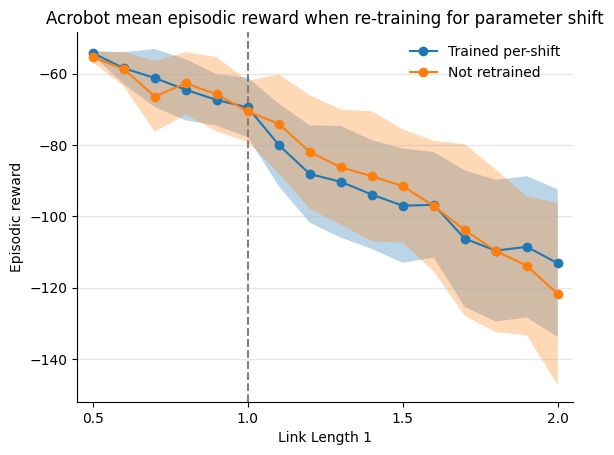

In [134]:
fig, ax = plt.subplots()

# Plot the shift-trained results
means = optimal_rewards.set_index('value')['best_mean_return']
yerr = optimal_rewards.set_index('value')['best_std_return']
x = means.index
y = means.values
yerr = yerr.values
ax.plot(x, y, marker='o', label='Trained per-shift')
ax.fill_between(x, y - yerr, y + yerr, alpha=0.3, zorder=-1)

# plot the un-retrained results
x = unoptimised_df.index
y = unoptimised_df['mean'].values
yerr = unoptimised_df['std'].values
ax.plot(x, y, marker='o', label='Not retrained')
ax.fill_between(x, y - yerr, y + yerr, alpha=0.3, zorder=-1)


# ax = optimal_rewards.plot(x='value', y='best_mean_return', marker='o', label='Trained on shift', yerr='best_std_return')
# # ax.plot(unoptimised_df['mean'], marker='o', label='Trained on nominal', yerr=unoptimised_df['std'])
# unoptimised_df.plot(y='mean', yerr='std', ax=ax, marker='o', label='')

ax.axvline(1.0, linestyle='--', c='k', alpha=0.5, zorder=-5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0.5, 1.0, 1.5, 2.0])
ax.set_xlim(0.45, 2.05)
ax.legend(frameon=False)
ax.set_xlabel('Link Length 1')
ax.set_ylabel('Episodic reward')
ax.set_ylabel('Episodic reward')
ax.set_title('Acrobot mean episodic reward when re-training for parameter shift')
ax.grid(which='major', axis='y', alpha=0.3, linewidth=1)